<h1><center>Crescimento da carteira</center></h1>
<center> Eduardo Vargas Ferreira

# 1 - Introdução

O objetivo dessa análise é estudar o crescimento da carteira para os próximos 4 anos, em termos do volume de operações e do tipo de carteira. A base de dados apresenta informações sobre operações de clientes de uma instituição financeira, bem como suas características socioeconômicas. Neste caso, vamos realizar algumas análises descritivas, e de forma mais específica entender os tipos de dados faltantes:

I) Missing completely at random (MCAR);

II) Missing at random - (MAR);

III) Missing not at random - MNAR

Inicialmente não aprenderemos como tratar esse tipo de problema, pois para isso devemos antes aprender outras técnicas, como validação cruzada.

# 2 - Importando as bibliotecas necessárias para o EDA

Inicialmente, vamos carregar algumas bibliotecas necessárias.

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 3 - Lendo os dados e realizando a primeira limpeza na base

In [2]:
base = pd.read_csv('dados_operacoes.csv', na_values='Null') 
base.head()

,id,contrato,data_operacao,nascimento,idade,genero,bairro,cidade,estado,cep,...,empregador,operacao,valor_principal,parcelas,quantidade_parcelas,parcelas_pagas,quantidade_parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto
0,682e8b505c30bb12052f9457516dc47e7eafc8ed,1760865030954,2019-09-13,1974-06-08,48.0,F,Conjunto Paulo Vi,Moreira,Rio de Janeiro,XXXXX-685,...,e53d5342e82e0ce6061bc3aaea1a986f24a73613,Prod,27810.69,100,100,20,20,1.46493,531.56,53156.0000
1,45ad9d444a276407df8b6f47c0fcc5b127dadaaa,6023030871505,2022-11-03,1988-07-23,34.0,F,Minas Caixa,da Mota de Azevedo,Amapá,XXXXX735,...,f715ffaf2c8294df43df3357c6a37f04b900fb06,Refin,9589.96,40,40,6,6,4.53587,523.82,20952.8000
2,81cec74ea2ca41535fee03daeb410ddbdf12906a,560263027614,2021-06-13,1975-08-17,NaN,NaN,Vila Mantiqueira,Rocha da Prata,Santa Catarina,XXXXX863,...,da9515ffa45dd12791be0941b91188e51fe1cc04,Prod,42963.20,100,100,10,10,1.44749,815.71,81571.0000
3,4e987d9178e2dcb07c2bf3878736233a676a0a87,1397061435926,2021-08-30,1982-08-17,40.0,F,Anchieta,da Mata,NaN,NaN,...,0c1741dc26339e6af3e4b6badcf984d383d1ca44,Port + Refin,2954.14,120,120,6,6,1.82904,60.96,7315.1997
4,595943ecdb32a24ccb6ef374b6d865f3b60d7130,3823566005671,2022-11-16,1985-07-14,37.0,F,Conjunto Floramar,Moreira de Goiás,Mato Grosso,XXXXX384,...,f97b240dc24290c19e717d7a654747aa31722ad3,Prod,31186.17,100,100,10,10,3.28340,1066.11,106611.0000


A base contém próximo de 15000 observações. Inicialmente, vamos eliminar a variável ‘id’ e ‘contrato’ por ser uma informação que, na prática, não tem relação com o problema. Além disso, a sua manutenção (e futura inclusão em um modelo), dependendo da forma em que ela é construída, pode trazer um vazamento dos dados. 

In [3]:
# Dropando variáveis que não serão usadas 
base.drop(['id','contrato'],1, inplace = True) # alterei a base original

Além disso, para a 'data_operacao' e 'nascimento', devemos alterar seu tipo.

In [4]:
base['data_operacao'] = pd.to_datetime(base['data_operacao'], format='%Y-%m-%d')

base['nascimento'] = pd.to_datetime(base['nascimento'], format='%Y-%m-%d')

print(base['data_operacao'].min(), base['data_operacao'].max())

base.isnull().sum(axis = 0) 

2019-01-01 00:00:00 2022-12-30 00:00:00


data_operacao                   0
nascimento                      0
idade                        3005
genero                       1487
bairro                       2539
cidade                       2831
estado                       2234
cep                          3754
telefone                     4655
cartao                       5279
email                        4667
ocupacao                     2271
empregador                   3124
operacao                        0
valor_principal                 0
parcelas                        0
quantidade_parcelas             0
parcelas_pagas                  0
quantidade_parcelas_pagas       0
taxa_contrato                   0
valor_parcela                   0
valor_bruto                     0
dtype: int64

# 4 - Dados faltantes

Note que temos dados faltantes na variável 'idade'. Neste caso, podemos facilmente inferir esses valores ausentes através da variável 'nascimento', mas vamos utilizar esse fato para entender os tipos de dados faltantes, porque dependendo da situação, devemos atuar de maneira diferente.

Se não houvesse a variável sobre a data de nascimento, não seria correto simplesmente eliminar a linha, pois o tipo de dado faltante pode não ser completamente aleatório (missing completely at random - MCAR). Ou seja, o dado missing pode ser somente aleatório (missing at random - MAR) e depender de outras variáveis, por exemplo, do gênero ou não aleatório (missing not at random - MNAR), que ocorre quando à própria idade do cliente é responsável pelo missing. 

### 4.1 - Missing completely at random (MCAR)

Vamos estudar cada um dos tipos de missing, a começar com o caso mais simples, em que os dados faltantes não tem qualquer relação com outras variáveis. 

In [5]:
# Criar uma cópia da base de dados
base1 = base.copy()

# Definir o tamanho da base de dados
num_rows = len(base1)

# Gerar índices aleatórios para definir os valores ausentes
indices_ausentes = np.random.choice(num_rows, size=int(num_rows * 0.3), replace=False)

# Definir os valores ausentes para a variável "idade"
base1.loc[:, 'idade'] = base1.loc[:, 'idade'].mask(base1.index.isin(indices_ausentes))

# Verificar a contagem de valores ausentes
print(base1.isnull().sum())

data_operacao                   0
nascimento                      0
idade                        6584
genero                       1487
bairro                       2539
cidade                       2831
estado                       2234
cep                          3754
telefone                     4655
cartao                       5279
email                        4667
ocupacao                     2271
empregador                   3124
operacao                        0
valor_principal                 0
parcelas                        0
quantidade_parcelas             0
parcelas_pagas                  0
quantidade_parcelas_pagas       0
taxa_contrato                   0
valor_parcela                   0
valor_bruto                     0
dtype: int64


Uma forma simples para se verificar a característica do dado faltante é através da inspeção gráfica. Por exemplo, abaixo analisamos essa questão com as variáveis 'gênero' (gráfico da esquerda) e 'valor principal' (gráfico da direita). Note que, em ambos os casos, a proporção de missing não tem relação com essas variáveis.  

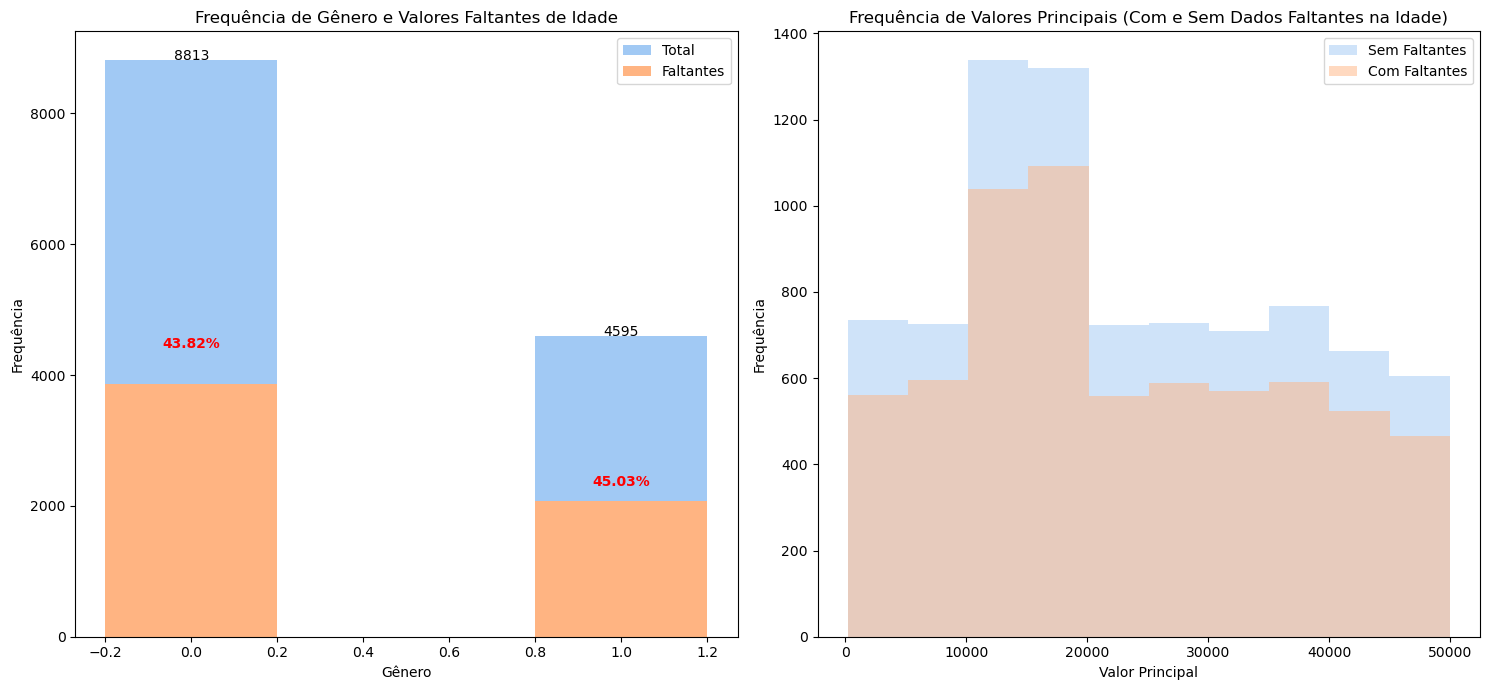

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar a base de dados por gênero e contar a frequência total por gênero
frequencia_genero = base1['genero'].value_counts()

# Filtrar a base de dados por gênero e por valores faltantes na coluna 'idade'
base_null = base1[base1['idade'].isnull()]
frequencia_null = base_null['genero'].value_counts()

# Calcular a proporção de valores faltantes da variável 'idade' em cada categoria de gênero
prop_missing = (frequencia_null / frequencia_genero).fillna(0)

# Configurar a figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Paleta de cores pastel
pastel_palette = sns.color_palette("pastel")

# Gráfico de barras da frequência de gênero e valores faltantes de idade
x = range(len(frequencia_genero))
axs[0].bar(x, frequencia_genero, width=0.4, label='Total', color=pastel_palette[0])
axs[0].bar(x, frequencia_null, width=0.4, label='Faltantes', color=pastel_palette[1])

# Adicionar valores nas barras e proporção de valores faltantes
for i, freq in enumerate(frequencia_genero):
    axs[0].text(i, freq + 5, str(freq), ha='center')
    prop = prop_missing[frequencia_genero.index[i]]
    axs[0].text(i, freq / 2, f"{prop:.2%}", ha='center', fontweight='bold', color='red')

# Configurar rótulos e título no primeiro subplot
axs[0].set_xlabel('Gênero')
axs[0].set_ylabel('Frequência')
axs[0].set_title('Frequência de Gênero e Valores Faltantes de Idade')
axs[0].legend()

# Histograma das frequências da variável 'valor_principal' com e sem dados faltantes na 'idade'
axs[1].hist(base1.loc[~base1['idade'].isnull(), 'valor_principal'], color=pastel_palette[0], alpha=0.5, label='Sem Faltantes')
axs[1].hist(base_null['valor_principal'], color=pastel_palette[1], alpha=0.5, label='Com Faltantes')

# Configurar rótulos e título no segundo subplot
axs[1].set_xlabel('Valor Principal')
axs[1].set_ylabel('Frequência')
axs[1].set_title('Frequência de Valores Principais (Com e Sem Dados Faltantes na Idade)')
axs[1].legend()

# Ajustar o espaçamento entre os subplots
fig.tight_layout()

# Exibir o gráfico
plt.show()


### 4.2 - Missing at random (MAR) 

Neste segundo caso - intencionalmente - fizemos com que o missing tivesse relação com outra variável da base, especificamente com 'valor principal'. Então, veja que no gráfico da esquerda a proporção de dados faltantes com relação ao gênero é praticamente a mesma, o que significa não haver relação com essa característica. Por outro lado, no gráfico da direita, note que quanto maior o 'valor principal' maior a proporção de missing. Ou seja, valor de contrato maiores tendem a apresentar uma maior ausência de informação com relação à idade. Nesse caso, se simplesmente excluirmos as linhas dos clientes que não informaram a idade, estaremos perdendo informações importantes, por exemplo, com relação ao valor principal.  

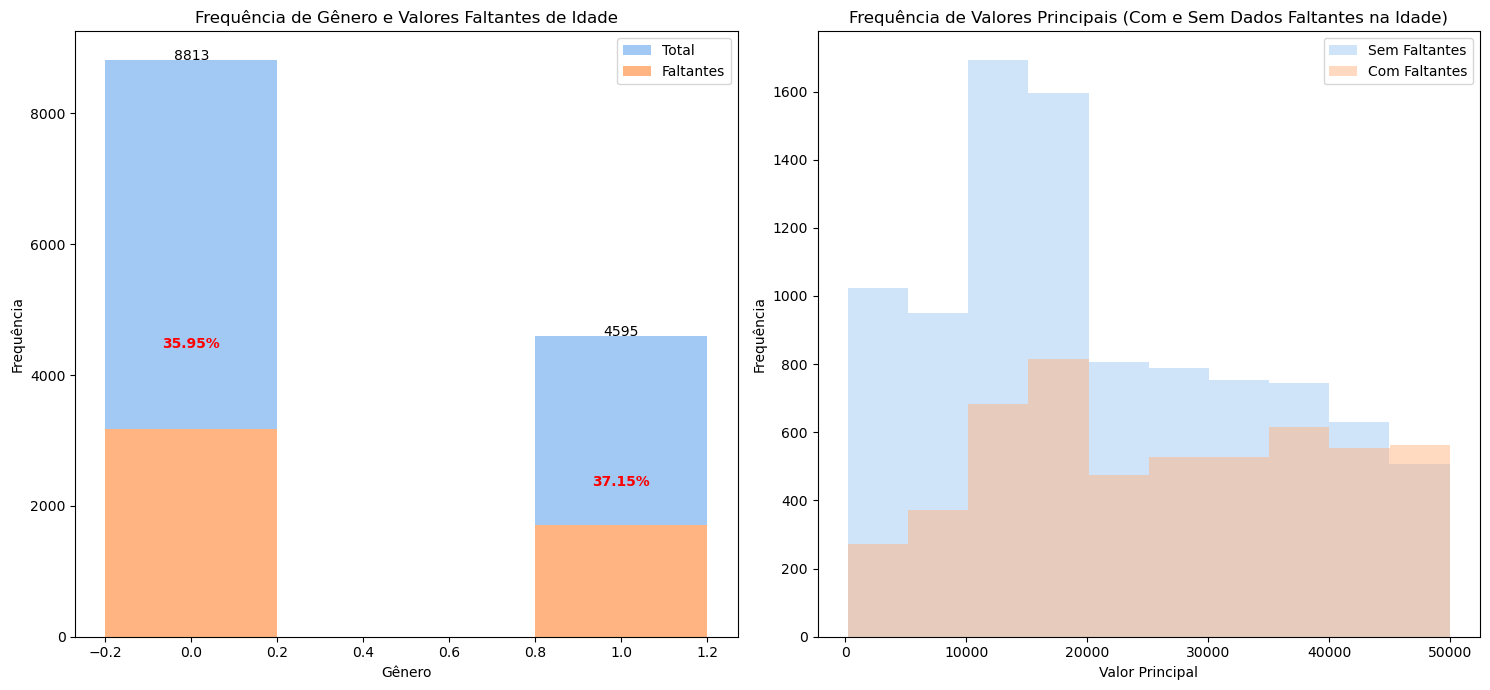

In [ ]:
# Crie uma cópia da base de dados
base2 = base.copy()

# Defina a taxa de dados faltantes desejada
missing_ratio = 0.2  # 20% de dados faltantes

# Calcule o número de linhas a serem afetadas pelo missing
num_rows = base2.shape[0]
num_missing = int(num_rows * missing_ratio)

# Ordene a base de dados pelo valor_principal em ordem decrescente
base2.sort_values(by='valor_principal', ascending=False, inplace=True)

# Normalize as probabilidades com base em 'valor_principal'
prob_missing = base2['valor_principal'] / base2['valor_principal'].sum()

# Atribua dados faltantes (NaN) com probabilidade baseada em 'valor_principal'
indices_ausentes = np.random.choice(base2.index, size=num_missing, replace=False, p=prob_missing)
base2.loc[indices_ausentes, 'idade'] = np.nan

# Filtrar a base de dados por gênero e contar a frequência total por gênero
frequencia_genero = base2['genero'].value_counts()

# Filtrar a base de dados por gênero e por valores faltantes na coluna 'idade'
base_null = base2[base2['idade'].isnull()]
frequencia_null = base_null['genero'].value_counts()

# Calcular a proporção de valores faltantes da variável 'idade' em cada categoria de gênero
prop_missing = (frequencia_null / frequencia_genero).fillna(0)

# Configurar a figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Paleta de cores pastel
pastel_palette = sns.color_palette("pastel")

# Gráfico de barras da frequência de gênero e valores faltantes de idade
x = range(len(frequencia_genero))
axs[0].bar(x, frequencia_genero, width=0.4, label='Total', color=pastel_palette[0])
axs[0].bar(x, frequencia_null, width=0.4, label='Faltantes', color=pastel_palette[1])

# Adicionar valores nas barras e proporção de valores faltantes
for i, freq in enumerate(frequencia_genero):
    axs[0].text(i, freq + 5, str(freq), ha='center')
    prop = prop_missing[frequencia_genero.index[i]]
    axs[0].text(i, freq / 2, f"{prop:.2%}", ha='center', fontweight='bold', color='red')

# Configurar rótulos e título no primeiro subplot
axs[0].set_xlabel('Gênero')
axs[0].set_ylabel('Frequência')
axs[0].set_title('Frequência de gênero e valores faltantes de idade')
axs[0].legend()

# Histograma das frequências da variável 'valor_principal' com e sem dados faltantes na 'idade'
axs[1].hist(base2.loc[~base2['idade'].isnull(), 'valor_principal'], color=pastel_palette[0], alpha=0.5, label='Sem Faltantes')
axs[1].hist(base_null['valor_principal'], color=pastel_palette[1], alpha=0.5, label='Com Faltantes')

# Configurar rótulos e título no segundo subplot
axs[1].set_xlabel('Valor Principal')
axs[1].set_ylabel('Frequência')
axs[1].set_title('Frequência de valores principais (com e sem dados faltantes na idade)')
axs[1].legend()

# Ajustar o espaçamento entre os subplots
fig.tight_layout()

# Exibir o gráfico
plt.show()


Alternativamente, os dados ausentes na variável 'idade' poderia ter relação com o gênero. Esse é o caso que veremos abaixo, em que a proporção de missing é diferente entre os gêneros.

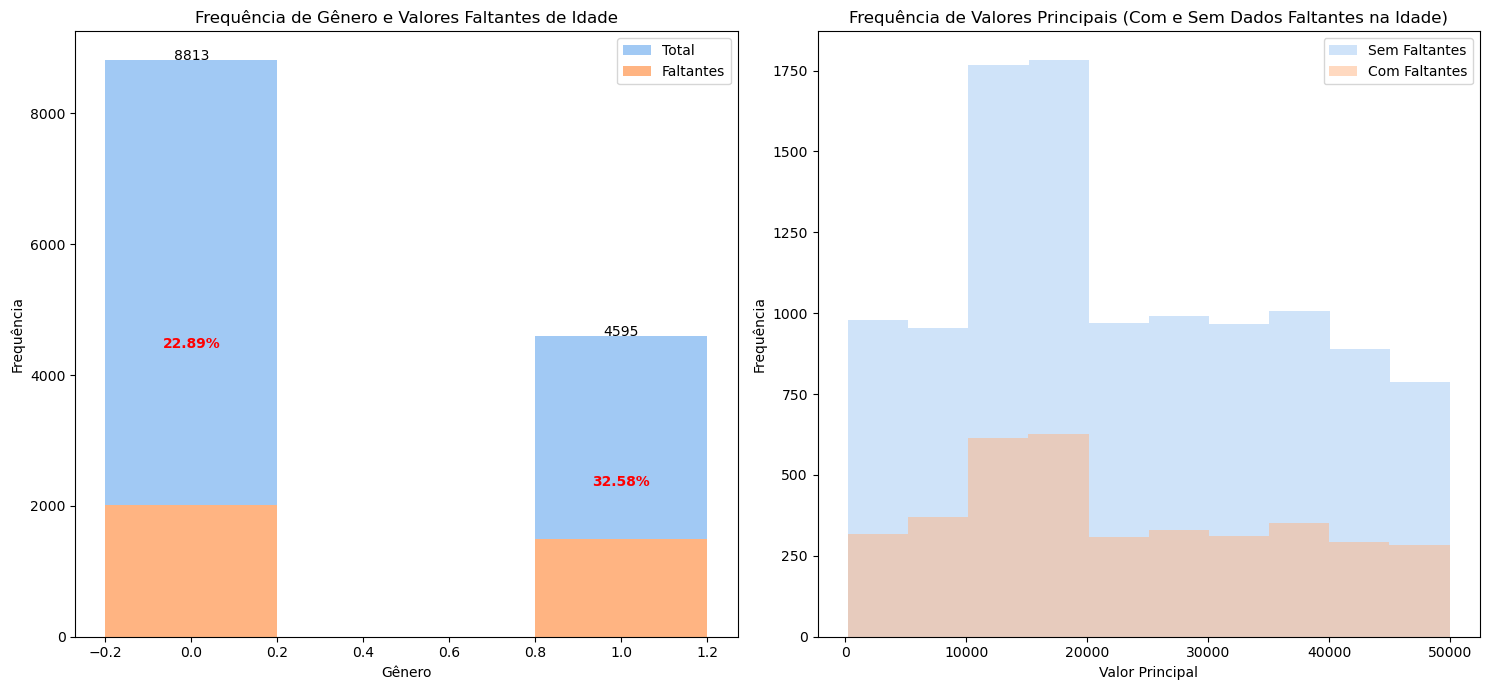

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crie uma cópia da base de dados
base3 = base.copy()

# Defina o número de dados faltantes desejado para cada gênero
missing_count_male = 700  # 700 dados faltantes para o gênero masculino
missing_count_female = 300  # 300 dados faltantes para o gênero feminino

# Obtenha os índices dos dados de cada gênero
indices_male = base3[base3['genero'] == 'M'].index
indices_female = base3[base3['genero'] == 'F'].index

# Atribua dados faltantes (NaN) para o gênero masculino
indices_ausentes_male = np.random.choice(indices_male, size=missing_count_male, replace=False)
base3.loc[indices_ausentes_male, 'idade'] = np.nan

# Atribua dados faltantes (NaN) para o gênero feminino
indices_ausentes_female = np.random.choice(indices_female, size=missing_count_female, replace=False)
base3.loc[indices_ausentes_female, 'idade'] = np.nan

# Filtrar a base de dados por gênero e contar a frequência total por gênero
frequencia_genero = base3['genero'].value_counts()

# Filtrar a base de dados por gênero e por valores faltantes na coluna 'idade'
base_null = base3[base3['idade'].isnull()]
frequencia_null = base_null['genero'].value_counts()

# Calcular a proporção de valores faltantes da variável 'idade' em cada categoria de gênero
prop_missing = (frequencia_null / frequencia_genero).fillna(0)

# Configurar a figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Paleta de cores pastel
pastel_palette = sns.color_palette("pastel")

# Gráfico de barras da frequência de gênero e valores faltantes de idade
x = range(len(frequencia_genero))
axs[0].bar(x, frequencia_genero, width=0.4, label='Total', color=pastel_palette[0])
axs[0].bar(x, frequencia_null, width=0.4, label='Faltantes', color=pastel_palette[1])

# Adicionar valores nas barras e proporção de valores faltantes
for i, freq in enumerate(frequencia_genero):
    axs[0].text(i, freq + 5, str(freq), ha='center')
    prop = prop_missing[frequencia_genero.index[i]]
    axs[0].text(i, freq / 2, f"{prop:.2%}", ha='center', fontweight='bold', color='red')

# Configurar rótulos e título no primeiro subplot
axs[0].set_xlabel('Gênero')
axs[0].set_ylabel('Frequência')
axs[0].set_title('Frequência de gênero e valores faltantes de idade')
axs[0].legend()

# Histograma das frequências da variável 'valor_principal' com e sem dados faltantes na 'idade'
axs[1].hist(base3.loc[~base3['idade'].isnull(), 'valor_principal'], color=pastel_palette[0], alpha=0.5, label='Sem Faltantes')
axs[1].hist(base_null['valor_principal'], color=pastel_palette[1], alpha=0.5, label='Com Faltantes')

# Configurar rótulos e título no segundo subplot
axs[1].set_xlabel('Valor Principal')
axs[1].set_ylabel('Frequência')
axs[1].set_title('Frequência de valores principais (com e sem dados faltantes na idade)')
axs[1].legend()

# Ajustar o espaçamento entre os subplots
fig.tight_layout()

# Exibir o gráfico
plt.show()


## 4.3 - Missing not at random (MNAR)

O último caso é o mais importante e o mais difícil de detectar, pois o dado faltante ocorre por conta da própria variável. Neste caso seria a situação em que a distribuição de missing é diferente quando variamos a idade. Conseguimos visualizar esse cenário, porque temos a variável 'nascimento' para nos auxiliar. 

In [9]:
# Create a copy of the base dataset
base4 = base.copy()

# Define the missing ratio
missing_ratio = 0.2  # Desired missing ratio

# Calculate the number of rows to be affected by missing values
num_rows = base4.shape[0]
num_missing = int(num_rows * missing_ratio)

# Generate missing values based on 'idade'
base4['idade_missing'] = np.where(base4['idade'] < np.random.uniform(size=num_rows), np.nan, base4['idade'])

# Randomly select rows to introduce missing values
indices_ausentes = np.random.choice(base4.index, size=num_missing, replace=False)
base4.loc[indices_ausentes, 'idade'] = np.nan

In [10]:
# Create a copy of the base dataset
base5 = base.copy()

# Define the missing ratio
missing_ratio = 0.2  # Desired missing ratio

# Sort the dataset by age in ascending order
base5 = base5.sort_values('idade')

# Calculate the number of rows to be affected by missing values
num_rows = base5.shape[0]
num_missing = int(num_rows * missing_ratio)

# Generate missing values based on 'idade' using a weighted random selection
missing_prob = np.linspace(1, 0.1, num_rows)  # Decrease missing probability with lower ages
missing_prob /= missing_prob.sum()  # Normalize the probabilities to sum to 1
missing_indices = np.random.choice(base5.index, size=num_missing, replace=False, p=missing_prob)

# Assign missing values to the 'idade' column at the selected indices
base5.loc[missing_indices, 'idade'] = np.nan

In [11]:
# Copiar a base original para usar no futuro
base_corrigida = base4.copy()

# Calcular a data atual
data_atual = datetime.today()

# Calcular a diferença entre a data atual e a data de nascimento
diferenca = data_atual - base['nascimento']

# Calcular a idade em anos aproximada
idade_aproximada = diferenca.dt.days // 365

# Preencher os dados faltantes na coluna 'idade' com os valores calculados
base_corrigida['idade'] = base['idade'].fillna(idade_aproximada)

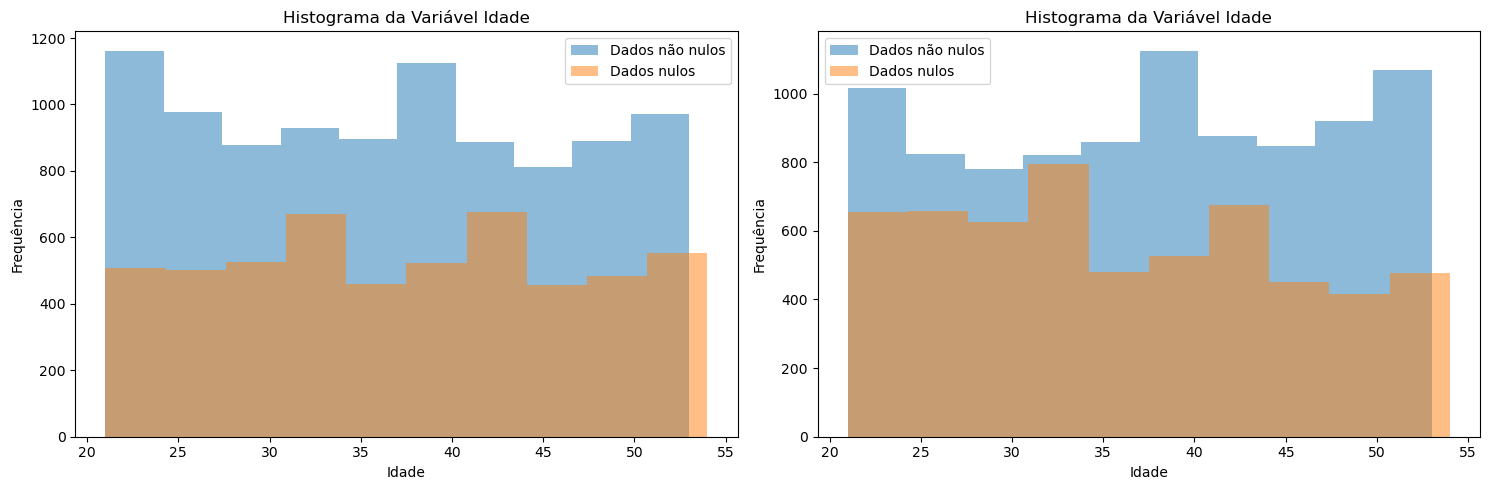

In [12]:
import matplotlib.pyplot as plt

# Filtrar as linhas em que base['idade'] é não nulo
idade_nao_null = base_corrigida['idade'][~base4['idade'].isnull()]

# Filtrar as linhas em que base['idade'] é nulo
idade_null = base_corrigida['idade'][base4['idade'].isnull()]

# Configurar o histograma para base['idade'] com base nas linhas não nulas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plotar o histograma dos dados não nulos
axs[0].hist(idade_nao_null, bins=10, alpha=0.5, label='Dados não nulos')

# Verificar se existem linhas com base['idade'] nulo
if idade_null.shape[0] > 0:
    # Configurar o histograma para base['idade'] com base nas linhas nulas
    axs[0].hist(idade_null, bins=10, alpha=0.5, label='Dados nulos')

# Adicionar rótulos e título no primeiro subplot
axs[0].set_xlabel('Idade')
axs[0].set_ylabel('Frequência')
axs[0].set_title('Histograma da Variável Idade')
axs[0].legend()

# Filtrar as linhas em que base['idade'] é não nulo
idade_nao_null1 = base_corrigida['idade'][~base5['idade'].isnull()]

# Filtrar as linhas em que base['idade'] é nulo
idade_null1 = base_corrigida['idade'][base5['idade'].isnull()]

# Configurar o histograma para base['idade'] com base nas linhas não nulas
# Plotar o histograma dos dados não nulos
axs[1].hist(idade_nao_null1, bins=10, alpha=0.5, label='Dados não nulos')

# Verificar se existem linhas com base['idade'] nulo
if idade_null1.shape[0] > 0:
    # Configurar o histograma para base['idade'] com base nas linhas nulas
    axs[1].hist(idade_null1, bins=10, alpha=0.5, label='Dados nulos')

# Adicionar rótulos e título no segundo subplot
axs[1].set_xlabel('Idade')
axs[1].set_ylabel('Frequência')
axs[1].set_title('Histograma da Variável Idade')
axs[1].legend()

# Ajustar o espaçamento entre os subplots
fig.tight_layout()

# Exibir o gráfico
plt.show()


# 5 - Análises adicionais sobre Missing

Existem várias maneiras para corrigir os dados faltantes, por exemplo, eliminando a linha por completo (isso é feito quando o processo é MCAR), ou utilizando outras variáveis para fazer esta estimação. Independente da abordagem, vamos criar uma variável indicadora, para que no futuro tenhamos o controle dessa alteração. 

In [13]:
# Criar a variável binária 'idade_missing'
base['genero_missing'] = np.where(base['genero'].isnull(), 1, 0)

print(base['genero_missing'])

0        0
1        0
2        1
3        0
4        0
        ..
14890    0
14891    0
14892    1
14893    0
14894    0
Name: genero_missing, Length: 14895, dtype: int64


Existem outras variáveis com dados ausentes.

In [14]:
base.isnull().sum(axis = 0) 

data_operacao                   0
nascimento                      0
idade                        3005
genero                       1487
bairro                       2539
cidade                       2831
estado                       2234
cep                          3754
telefone                     4655
cartao                       5279
email                        4667
ocupacao                     2271
empregador                   3124
operacao                        0
valor_principal                 0
parcelas                        0
quantidade_parcelas             0
parcelas_pagas                  0
quantidade_parcelas_pagas       0
taxa_contrato                   0
valor_parcela                   0
valor_bruto                     0
genero_missing                  0
dtype: int64

Não será proposto qualquer procedimento de imputação na variável gênero, pois, em princípio, essa informação não deveria ser relacionada com o objetivo principal da análise, que é projetar o crescimento da carteira nos próximos 4 anos. O mesmo argumento vale para as variáveis 'bairro' e 'cidade', que muito embora seus valores nulos podem ser obtidos à partir do CEP, tais variáveis não entrarão nas análises futuras, pois elas não trazem um "sinal" relevante sobre o problema. 

Já para a variável 'empregador', existe a possibilidade dos valores faltantes serem decorrentes da falta de um empregador propriamente (processo MNAR), por exemplo, profissionais liberais, mas isso será deixado para melhorias futuras. 

Por fim, eliminaremos as observações que apresentam valores ausentes nas variáveis 'telefone', 'cartao' e 'e-mail' ao mesmo tempo. Isso seria feito após uma consulta mais detalhada e estudos adicionais. Mas, para essa análise, foi considerado que a ausência de tantas informações importantes sobre o cliente não é algo comum, ou seja, não faz parte do "comportamento padrão" dos clientes, e seriam portanto outliers. 

In [15]:
# Verificar as linhas com valores ausentes nas variáveis 'telefone', 'cartao' e 'e-mail' ao mesmo tempo
linhas_remover = base[['telefone', 'cartao', 'email']].isnull().all(axis=1)

# Remover as linhas da base com valores ausentes nas variáveis 'telefone', 'cartao' e 'e-mail' ao mesmo tempo
base = base.dropna(subset=['telefone', 'cartao', 'email'], how='all')